<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/option/options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df_ce=pd.read_csv('/content/OPTIDX_NIFTY_CE_30-Aug-2024_TO_31-Oct-2024.csv')
df_pe=pd.read_csv('/content/OPTIDX_NIFTY_PE_30-Aug-2024_TO_31-Oct-2024.csv')

<ipython-input-13-556707209e70>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pe=pd.read_csv('/content/OPTIDX_NIFTY_PE_30-Aug-2024_TO_31-Oct-2024.csv')


In [ ]:
# Standardizing column names for merging
df_ce.columns = df_ce.columns.str.strip().str.replace(" ", "_")
df_pe.columns = df_pe.columns.str.strip().str.replace(" ", "_")

# Merging on common columns: Symbol, Date, Expiry, Strike_Price, and Underlying_Value
merged_df_aug_to_oct = pd.merge(
    df_ce, df_pe,
    on=["Symbol", "Date", "Expiry", "Strike_Price", "Underlying_Value"],
    suffixes=("_CE", "_PE")
)




In [ ]:
merged_df_aug_to_oct.to_csv('merged_df_aug_to_oct.csv', index=False)

In [ ]:
# File paths
files = [
    "/content/Merged_df_jan_to_mar.csv",
    "/content/merged_df_mar_to_jun.csv",
    "/content/merged_df_jun_to_aug.csv",
    "/content/merged_df_aug_to_oct.csv"
]

# Load and concatenate all files based on the 'Date' column
dfs = [pd.read_csv(file) for file in files]

# Ensure 'Date' column is in datetime format for proper merging and sorting
for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Concatenate all dataframes
merged_final_df = pd.concat(dfs).sort_values(by="Date").reset_index(drop=True)


<ipython-input-16-e90c12ba274d>:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(file) for file in files]
<ipython-input-16-e90c12ba274d>:10: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(file) for file in files]


In [ ]:
merged_final_df.to_csv('merged_final_df.csv', index=False)

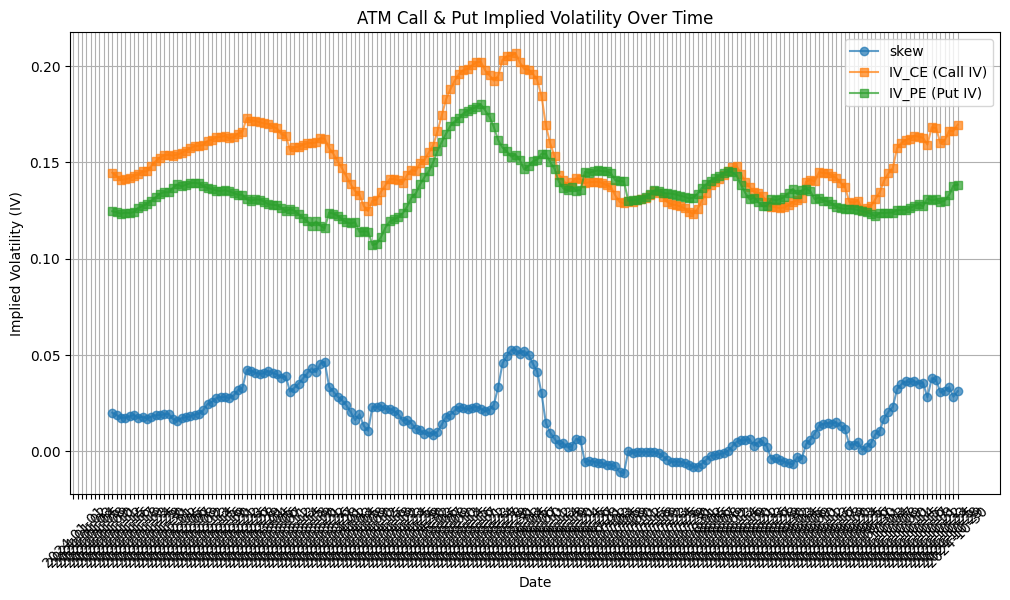

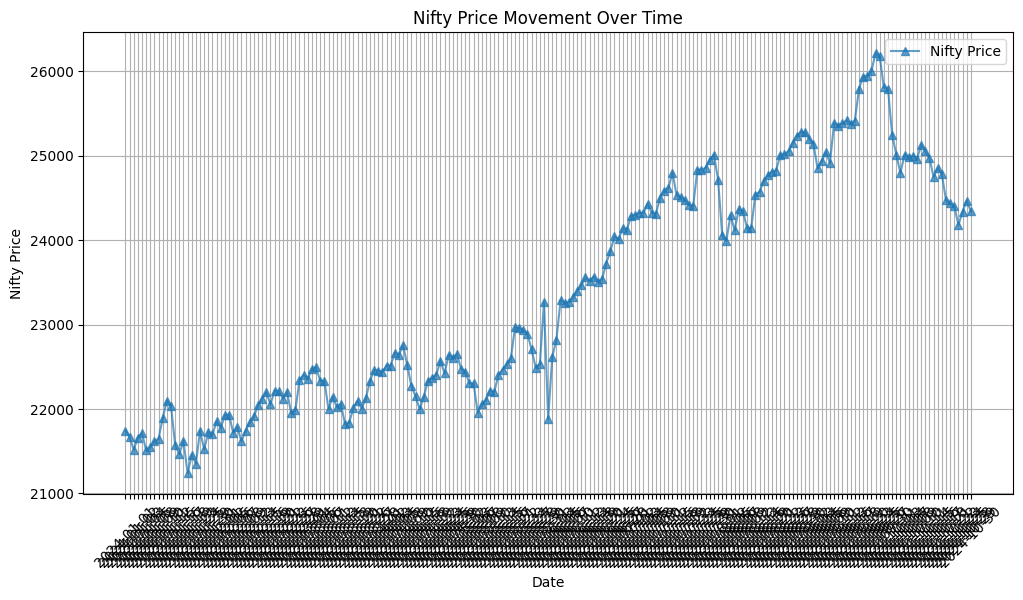

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
atm_df= pd.read_csv('/content/ATM_IV_Data.csv')
# Plot IV_CE and IV_PE over time
plt.figure(figsize=(12, 6))
plt.plot(atm_df['Date'], atm_df['IV_CE'].rolling(window=10).mean()-atm_df['IV_PE'].rolling(window=10).mean(), label="skew", marker='o', linestyle='-', alpha=0.7)
plt.plot(atm_df['Date'], atm_df['IV_CE'].rolling(window=10).mean(),label='IV_CE (Call IV)',marker='s',linestyle='-',alpha=0.7)
plt.plot(atm_df['Date'], atm_df['IV_PE'].rolling(window=10).mean(), label="IV_PE (Put IV)", marker='s', linestyle='-', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Implied Volatility (IV)")
plt.title("ATM Call & Put Implied Volatility Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot IV vs. Underlying Price
plt.figure(figsize=(12, 6))
plt.plot(atm_df['Date'], atm_df['Underlying_Price'], label="Nifty Price", marker='^', linestyle='-', alpha=0.7)
plt.ylabel("Nifty Price")
plt.xlabel("Date")
plt.title("Nifty Price Movement Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [6]:
import pandas as pd
from scipy.stats import percentileofscore

def put_iv_percentile(iv_pe_series):
    """
    Calculate the percentile score of the most recent IV_PE value
    compared to its historical distribution.

    :param iv_pe_series: A Pandas Series containing historical IV_PE values.
    :return: Percentile score (0-100) indicating how high the latest IV_PE is.
    """
    if len(iv_pe_series) < 10:
        return "Not enough data for percentile calculation."

    latest_iv_pe = iv_pe_series.iloc[-1]  # Most recent IV_PE
    percentile_score = percentileofscore(iv_pe_series, latest_iv_pe, kind='rank')

    return percentile_score

# Example usage:
# Assuming 'atm_df' is your DataFrame containing the 'IV_PE' column
iv_pe_series = atm_df['IV_PE'].dropna()
iv_percentile = put_iv_percentile(iv_pe_series)

print(f"Current IV_PE Percentile Score: {iv_percentile:.2f}%")


Current IV_PE Percentile Score: 41.95%


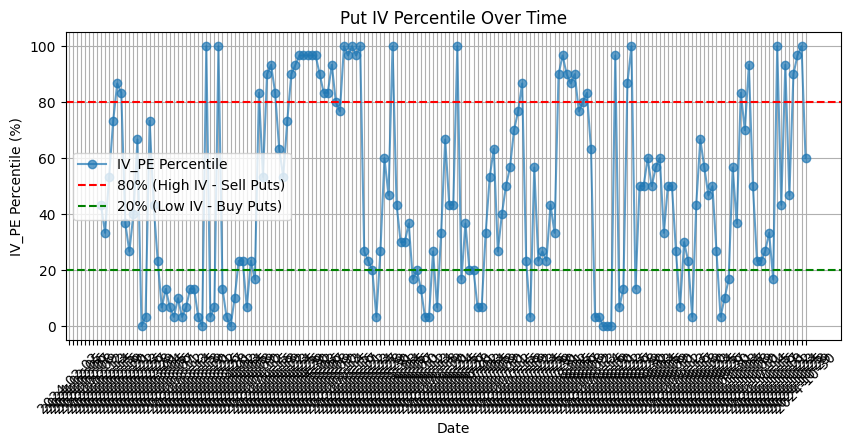

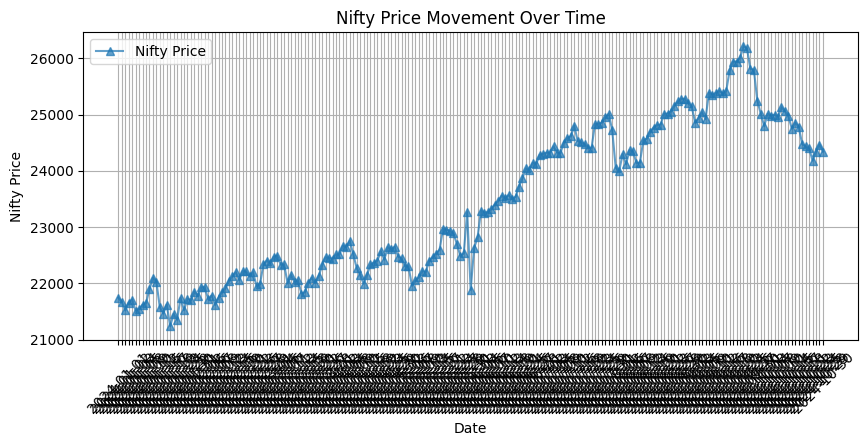

In [10]:
# Ensure IV_PE is numeric and drop NaNs
atm_df['IV_PE'] = pd.to_numeric(atm_df['IV_PE'], errors='coerce')

# Function to compute rolling percentile for IV_PE
def rolling_percentile(series, window=30):
    """Compute rolling percentile for a given series."""
    percentiles = [None] * window  # Pre-fill with None for first 'window' values
    for i in range(window, len(series)):
        rolling_window = series[i - window : i]  # Get past 'window' values
        percentiles.append(percentileofscore(rolling_window, series.iloc[i], kind='rank'))
    return percentiles

# Apply rolling percentile calculation
atm_df['IV_PE_Percentile'] = rolling_percentile(atm_df['IV_PE'].dropna(), window=30)

# Plot IV_PE Percentile over time
plt.figure(figsize=(10,4))
plt.plot(atm_df['Date'], atm_df['IV_PE_Percentile'], marker='o', linestyle='-', label="IV_PE Percentile", alpha=0.7)
plt.axhline(80, color='red', linestyle='--', label="80% (High IV - Sell Puts)")
plt.axhline(20, color='green', linestyle='--', label="20% (Low IV - Buy Puts)")

plt.xlabel("Date")
plt.ylabel("IV_PE Percentile (%)")
plt.title("Put IV Percentile Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot IV vs. Underlying Price
plt.figure(figsize=(10,4))
plt.plot(atm_df['Date'], atm_df['Underlying_Price'], label="Nifty Price", marker='^', linestyle='-', alpha=0.7)
plt.ylabel("Nifty Price")
plt.xlabel("Date")
plt.title("Nifty Price Movement Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

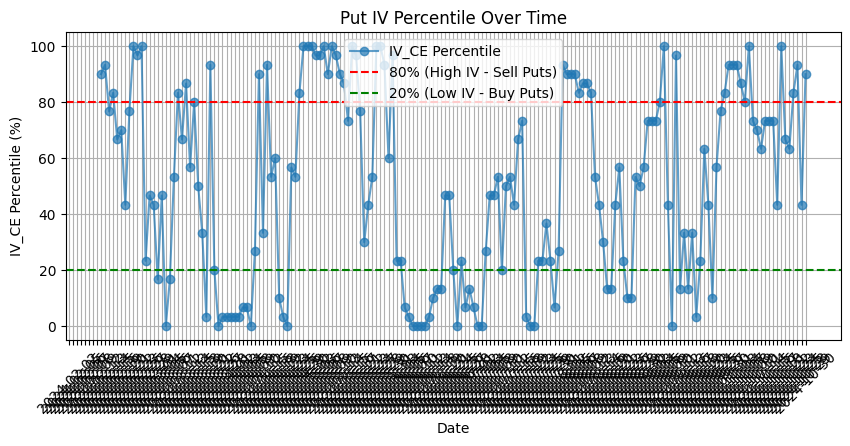

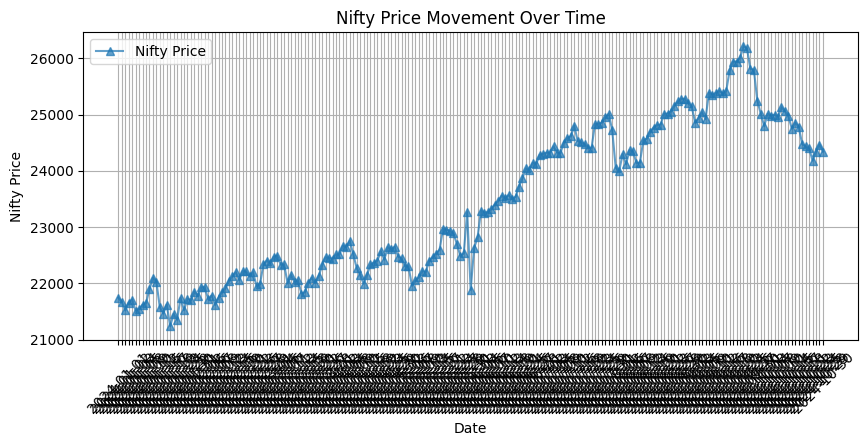

In [11]:
# Ensure IV_PE is numeric and drop NaNs
atm_df['IV_PE'] = pd.to_numeric(atm_df['IV_PE'], errors='coerce')

# Function to compute rolling percentile for IV_PE
def rolling_percentile(series, window=30):
    """Compute rolling percentile for a given series."""
    percentiles = [None] * window  # Pre-fill with None for first 'window' values
    for i in range(window, len(series)):
        rolling_window = series[i - window : i]  # Get past 'window' values
        percentiles.append(percentileofscore(rolling_window, series.iloc[i], kind='rank'))
    return percentiles

# Apply rolling percentile calculation
atm_df['IV_CE_Percentile'] = rolling_percentile(atm_df['IV_CE'].dropna(), window=30)

# Plot IV_PE Percentile over time
plt.figure(figsize=(10,4))
plt.plot(atm_df['Date'], atm_df['IV_CE_Percentile'], marker='o', linestyle='-', label="IV_CE Percentile", alpha=0.7)
plt.axhline(80, color='red', linestyle='--', label="80% (High IV - Sell Puts)")
plt.axhline(20, color='green', linestyle='--', label="20% (Low IV - Buy Puts)")

plt.xlabel("Date")
plt.ylabel("IV_CE Percentile (%)")
plt.title("Put IV Percentile Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot IV vs. Underlying Price
plt.figure(figsize=(10,4))
plt.plot(atm_df['Date'], atm_df['Underlying_Price'], label="Nifty Price", marker='^', linestyle='-', alpha=0.7)
plt.ylabel("Nifty Price")
plt.xlabel("Date")
plt.title("Nifty Price Movement Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

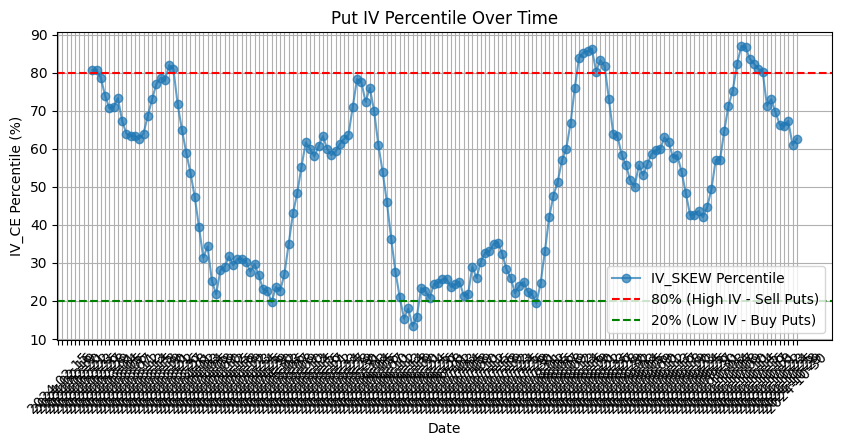

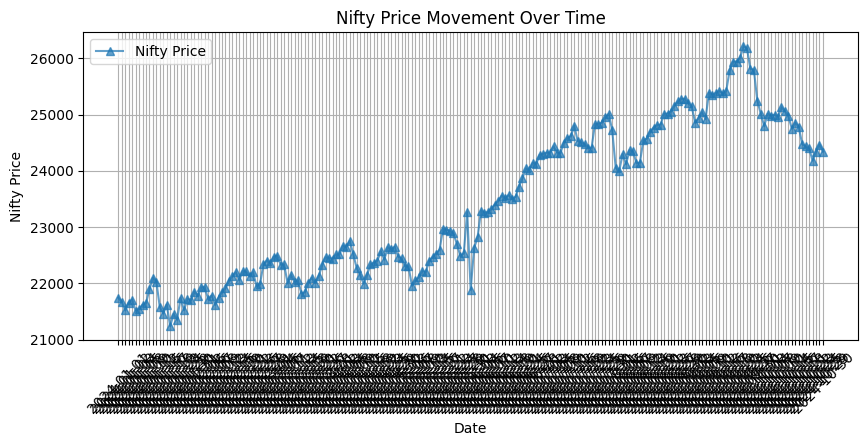

In [15]:
# Ensure IV_PE is numeric and drop NaNs
atm_df['skew'] = pd.to_numeric(atm_df['IV_CE'], errors='coerce')-pd.to_numeric(atm_df['IV_PE'], errors='coerce')

# Function to compute rolling percentile for IV_PE
def rolling_percentile(series, window=30):
    """Compute rolling percentile for a given series."""
    percentiles = [None] * window  # Pre-fill with None for first 'window' values
    for i in range(window, len(series)):
        rolling_window = series[i - window : i]  # Get past 'window' values
        percentiles.append(percentileofscore(rolling_window, series.iloc[i], kind='rank'))
    return percentiles

# Apply rolling percentile calculation
atm_df['IV_SKEW_Percentile'] = rolling_percentile(atm_df['skew'].dropna(), window=30)

# Plot IV_PE Percentile over time
plt.figure(figsize=(10,4))
plt.plot(atm_df['Date'], atm_df['IV_SKEW_Percentile'].rolling(window=10).mean(), marker='o', linestyle='-', label="IV_SKEW Percentile", alpha=0.7)
plt.axhline(80, color='red', linestyle='--', label="80% (High IV - Sell Puts)")
plt.axhline(20, color='green', linestyle='--', label="20% (Low IV - Buy Puts)")

plt.xlabel("Date")
plt.ylabel("IV_CE Percentile (%)")
plt.title("Put IV Percentile Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot IV vs. Underlying Price
plt.figure(figsize=(10,4))
plt.plot(atm_df['Date'], atm_df['Underlying_Price'], label="Nifty Price", marker='^', linestyle='-', alpha=0.7)
plt.ylabel("Nifty Price")
plt.xlabel("Date")
plt.title("Nifty Price Movement Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()